# Fatal Police Shootings Dataset (v2)

This repository contains version 2 of the Washington Post’s publicly available dataset on fatal police shootings in the United States since 2015.

---

## Variables ##

### `fatal-police-shootings-data.csv`
Contains detailed information on each recorded fatal police shooting incident, with the following key fields:

- **Incident Metadata**
  - `id`: Unique identifier for each case.
  - `date`, `city`, `state`, `county`: Location details of the incident.
  - `latitude`, `longitude`: Geographic coordinates.
  - `location_precision`: Indicates if the geolocation is precise (e.g., exact address, block).

- **Victim Information**
  - `name`, `age`,`gender`
  - `race`: Supports multiple racial classifications.
  - `race_source`: Indicates how race was determined (e.g., official report, visual confirmation).

- **Incident Context**
  - `armed_with`: Standardized classification of weapon type (including "toy", "unarmed", "replica" etc.).
  - `threat_level`: High(gun) Medium=(knife) Low(anyther other than gun or knife)
  - `flee_status`: How the victim fleed or not
  - `mental_illness`: Boolen

  - `body_camera`: Indicates if footage was recorded.

- **Agency Involvement**
  - `agency_ids`: List of unique identifiers for involved law enforcement agencies.



In [4]:
import pandas as pd
import numpy as np
from google.colab import drive
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE, ADASYN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")


In [91]:
drive.mount('/content/drive')

fps = pd.read_csv("/content/drive/MyDrive/Machine_learning/fatal-police-shootings-data.csv")

#p_t = pd.read_csv("/content/drive/MyDrive/Machine_learning/Police_Training.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fps.describe()

,id,latitude,longitude,age
count,10428.000000,9297.000000,9296.000000,10046.000000
mean,5719.947161,36.637198,-96.863533,37.470735
std,3240.079901,5.361694,16.338726,12.934005
min,3.000000,19.497503,-160.006944,0.000000
25%,2911.750000,33.451306,-111.953955,28.000000
50%,5751.500000,36.065011,-94.190367,35.000000
75%,8525.250000,40.043209,-83.126559,45.000000
max,11295.000000,71.301255,-67.867166,92.000000


In [ ]:
fps.dtypes

,0
id,int64
date,object
threat_type,object
flee_status,object
armed_with,object
city,object
county,object
state,object
latitude,float64
longitude,float64


In [ ]:
fps.head()

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


In [ ]:
fps.shape

(10428, 19)

In [6]:
fps['date'] = pd.to_datetime(fps['date'])

print(fps.head())

   id       date threat_type flee_status armed_with           city  \
0   3 2015-01-02       point         not        gun        Shelton   
1   4 2015-01-02       point         not        gun          Aloha   
2   5 2015-01-03        move         not    unarmed        Wichita   
3   8 2015-01-04       point         not    replica  San Francisco   
4   9 2015-01-04       point         not      other          Evans   

          county state   latitude   longitude location_precision  \
0          Mason    WA  47.246826 -123.121592      not_available   
1     Washington    OR  45.487421 -122.891696      not_available   
2       Sedgwick    KS  37.694766  -97.280554      not_available   
3  San Francisco    CA  37.762910 -122.422001      not_available   
4           Weld    CO  40.383937 -104.692261      not_available   

                 name   age gender race    race_source  \
0          Tim Elliot  53.0   male    A  not_available   
1    Lewis Lee Lembke  47.0   male    W  not_available

In [ ]:
print(fps.head())

        id       date threat_type flee_status armed_with             city  \
4923  5342 2020-01-01       point         not    replica     Grass Valley   
4924  5344 2020-01-01      threat         not        gun  Richmond County   
4925  5347 2020-01-01       point         not        gun    Central Point   
4926  5403 2020-01-01      attack         not      knife           Denver   
4927  5339 2020-01-02       shoot         car        gun             Holt   

     county state   latitude   longitude location_precision  \
4923    NaN    CA  39.219061 -121.061061      not_available   
4924    NaN    VA  38.100439  -76.875280      not_available   
4925    NaN    OR  42.417503 -122.993133      not_available   
4926    NaN    CO  39.700105 -105.029967      not_available   
4927    NaN    MO  39.404370  -94.344982      not_available   

                                name   age gender race    race_source  \
4923              Gabriel Strickland  25.0   male    W  not_available   
4924        

In [329]:
fps[['body_camera', 'race']].value_counts(ascending=False)

body_camera  race 
False        W        3998
             B        1894
             H        1416
True         W         649
             B         585
             H         300
False        A         134
             N         116
True         A          50
False        O          31
True         N          29
             O           6
False        B;H         2
True         W;B         2
False        W;B         2
             W;H         2
             W;B;N       1
             N;H         1
True         W;A         1
             W;H         1
Name: count, dtype: int64

In [330]:
print('Armed With\n', fps['armed_with'].unique())
print('\nflee Status\n',fps['flee_status'].unique())

Armed With
 ['gun' 'unarmed' 'replica' 'other' 'knife' nan 'blunt_object' 'vehicle'
 'undetermined' 'other;gun' 'unknown' 'blunt_object;blunt_object'
 'gun;knife' 'knife;blunt_object' 'vehicle;gun' 'gun;vehicle'
 'replica;vehicle' 'blunt_object;knife' 'knife;vehicle'
 'vehicle;knife;other' 'knife;knife' 'replica;knife'
 'other;blunt_object;knife' 'other;knife' 'vehicle;knife' 'gun;other'
 'blunt_object;other' 'knife;replica' 'knife;unknown'
 'replica;blunt_object' 'blunt_object;gun']

flee Status
 ['not' 'car' 'foot' 'other' nan]


In [331]:
print("\nClass Distribution:")
print(fps['race'].value_counts(normalize=True))



Class Distribution:
race
W        0.504013
B        0.268872
H        0.186117
A        0.019957
N        0.015727
O        0.004013
W;B      0.000434
W;H      0.000325
B;H      0.000217
W;B;N    0.000108
N;H      0.000108
W;A      0.000108
Name: proportion, dtype: float64


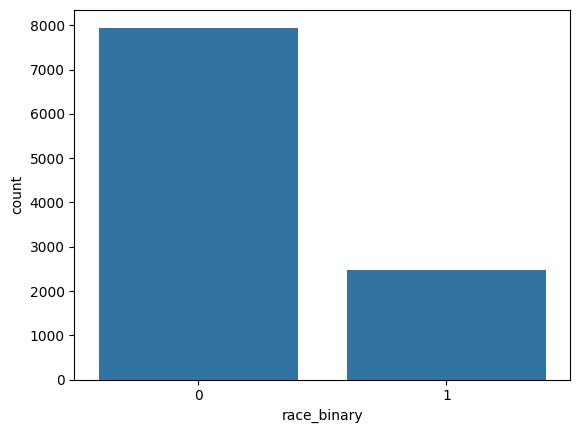

In [ ]:
sns.countplot(data=fps, x='race_binary')
plt.show()

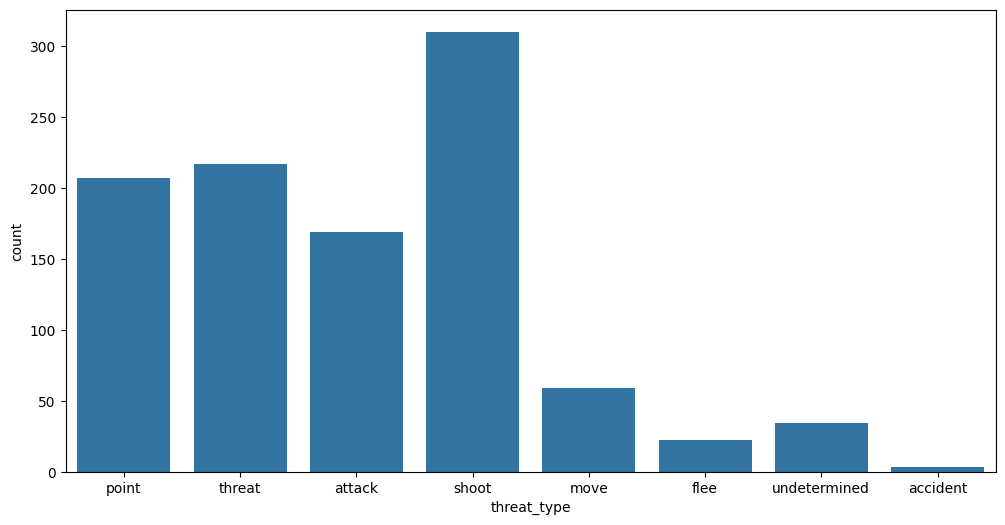

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))
sns.countplot(data=fps, x='threat_type')
plt.show()

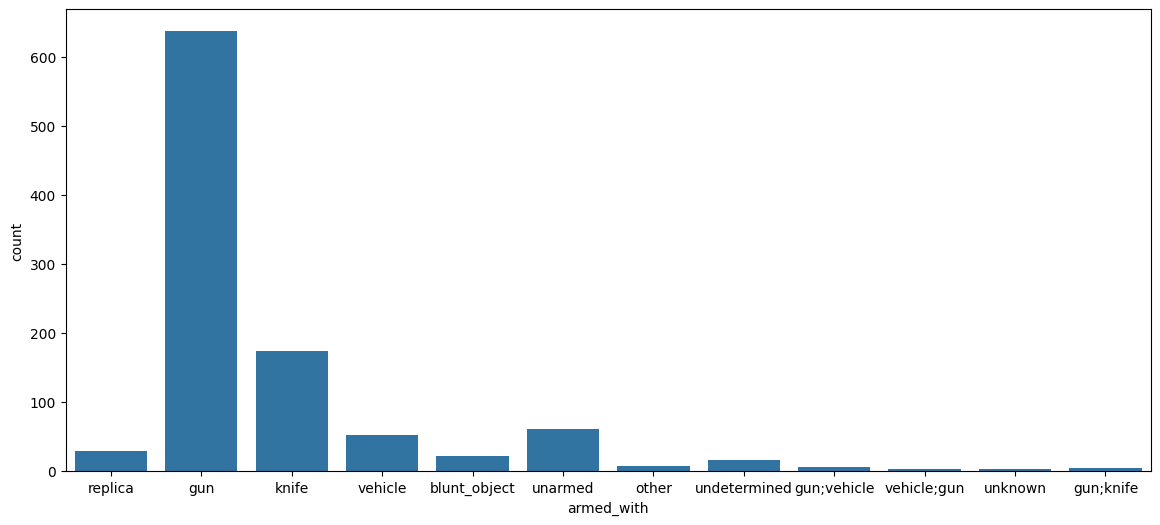

In [ ]:
fig, axs = plt.subplots(figsize=(14, 6))
sns.countplot(data=fps, x='armed_with')
plt.show()

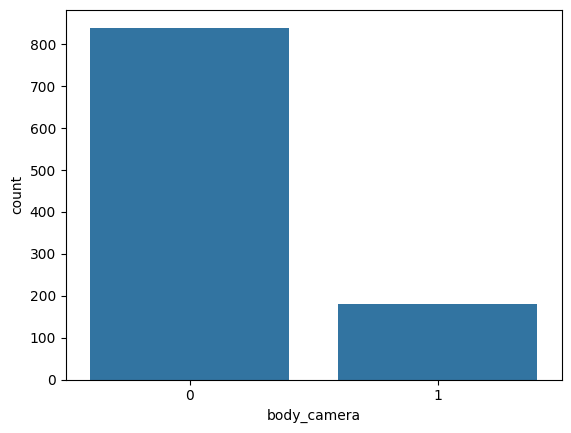

In [ ]:
sns.countplot(data=fps, x='body_camera')
plt.show()

In [344]:
missing_values_perc = fps.isnull().sum() / fps.shape[0] * 100
print(missing_values_perc)

id                             0.000000
date                           0.000000
threat_type                    0.652091
flee_status                   14.355581
armed_with                     2.023399
city                           0.709628
county                        44.984657
state                          0.000000
latitude                      10.845800
longitude                     10.855389
location_precision            10.845800
name                           3.145378
age                            3.663214
gender                         0.268508
race                          11.584196
race_source                   11.373226
was_mental_illness_related     0.000000
body_camera                    0.000000
agency_ids                     0.009590
dtype: float64


In [484]:
#Columns that have missing values exceeding 15% in the dataset
missing_values_column = missing_values_perc[missing_values_perc > 15].keys()
print(missing_values_column)

Index(['county'], dtype='object')


In [483]:
#Find all the columns with the missing values
for column in fps.columns:
  print(f'{column}: {fps[column].isnull().sum()}')

id: 0
date: 0
threat_type: 68
flee_status: 1497
armed_with: 211
city: 74
county: 4691
state: 0
latitude: 1131
longitude: 1132
location_precision: 1131
name: 328
age: 382
gender: 28
race: 1208
race_source: 1186
was_mental_illness_related: 0
body_camera: 0
agency_ids: 1


In [8]:

fps1=fps.drop('county',axis=1)

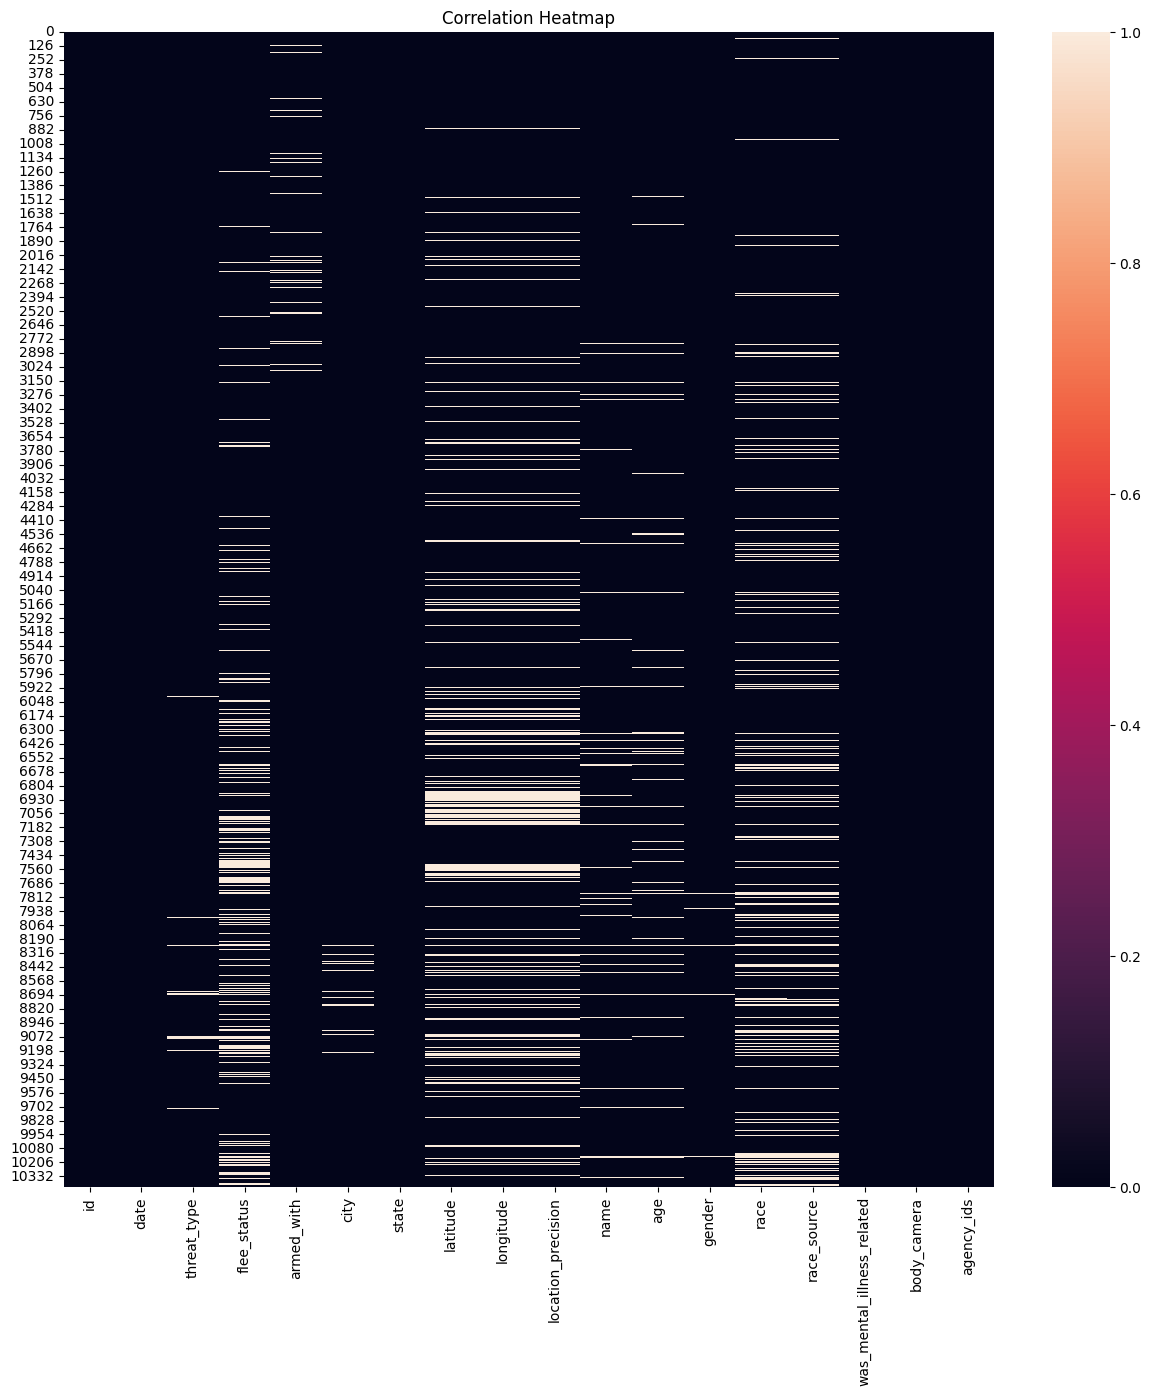

In [486]:
plt.figure(figsize = (15,15))
sns.heatmap(fps.isnull())
plt.title("Correlation Heatmap")
plt.show()

In [9]:
fps1['race'].unique()

array(['A', 'W', 'H', 'B', 'O', nan, 'N', 'W;B;N', 'N;H', 'W;H', 'B;H',
       'W;B', 'W;A'], dtype=object)

In [95]:
fps1=fps

In [96]:
fps1['race_code'] = fps1['race'].map({
    'W':1,
    'B': 2,
    'H': 3,
    'A': 4,
    'N': 5,
})
print(fps1['race_code'].value_counts())

race_code
1.0    4647
2.0    2479
3.0    1716
4.0     184
5.0     145
Name: count, dtype: int64


In [12]:
print(fps['race_code'].value_counts())


race_code
1.0    4647
2.0    2479
3.0    1716
4.0     184
5.0     145
Name: count, dtype: int64


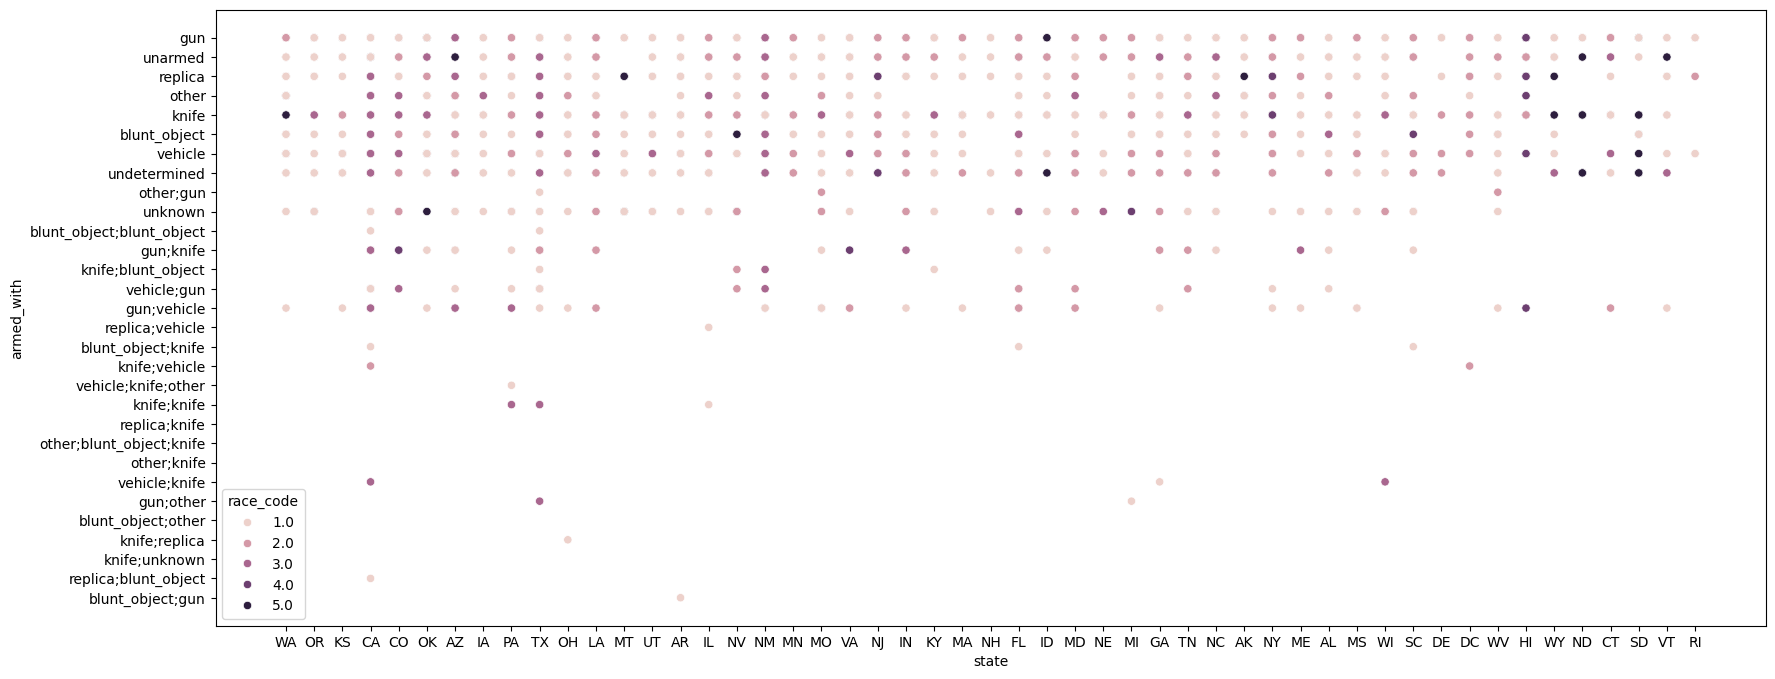

In [284]:
fig, axs = plt.subplots(figsize=(20,8))
sns.scatterplot(x='state',y='armed_with',data=fps,hue='race_code')
plt.show()

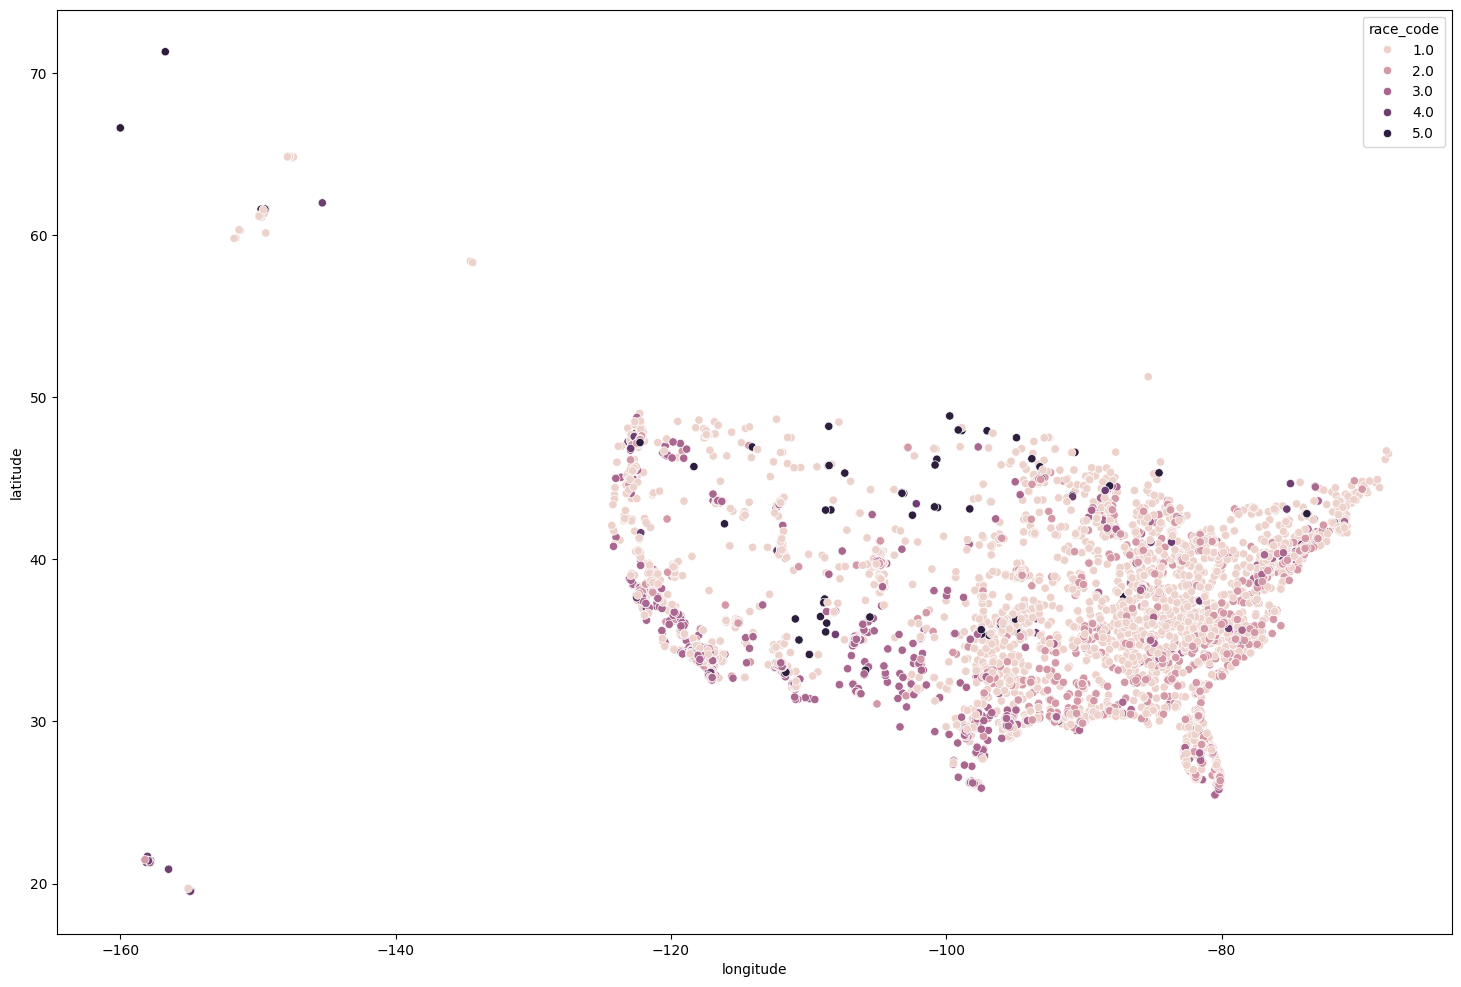

In [285]:
fig, axs = plt.subplots(figsize=(18,12))
sns.scatterplot(x='longitude',y='latitude',data=fps,hue='race_code')
plt.show()


In [296]:
fps[['state','race_code']].head(25).sort_values(by=['race_code'], ascending=True)

,state,race_code
1,OR,1.0
3,CA,1.0
7,KS,1.0
5,OK,1.0
13,IA,1.0
15,MT,1.0
10,CA,1.0
8,IA,1.0
21,IL,1.0
19,AR,1.0


from matplotlib import pyplot as plt
_df_0['race_code'].plot(kind='hist', bins=20, title='race_code')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['race_code']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'race_code'}, axis=1)
              .sort_values('race_code', ascending=True))
  xs = counted['race_code']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('race_code', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('race_code')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_2['race_code'].plot(kind='line', figsize=(8, 4), title='race_code')
plt.gca().spines[['top', 'right']].set_visible(False)

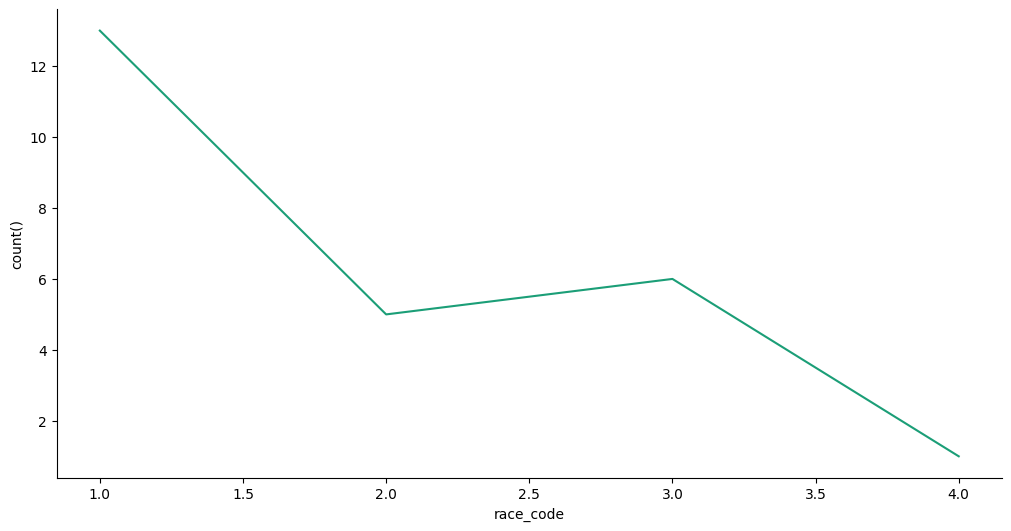

In [489]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['race_code']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'race_code'}, axis=1)
              .sort_values('race_code', ascending=True))
  xs = counted['race_code']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('race_code', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('race_code')
_ = plt.ylabel('count()')

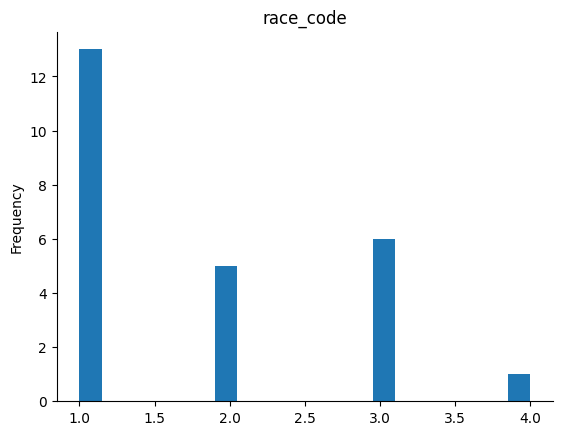

In [297]:
from matplotlib import pyplot as plt
_df_0['race_code'].plot(kind='hist', bins=20, title='race_code')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
state_counts= fps[['state','race_code']].value_counts()
state_counts_df = state_counts.to_frame(name='counts')
print(state_counts_df)

                 counts
state race_code        
CA    3.0           554
TX    1.0           391
      3.0           357
CA    1.0           349
FL    1.0           307
...                 ...
VA    5.0             1
TX    5.0             1
VT    3.0             1
VA    4.0             1
WV    4.0             1

[204 rows x 1 columns]


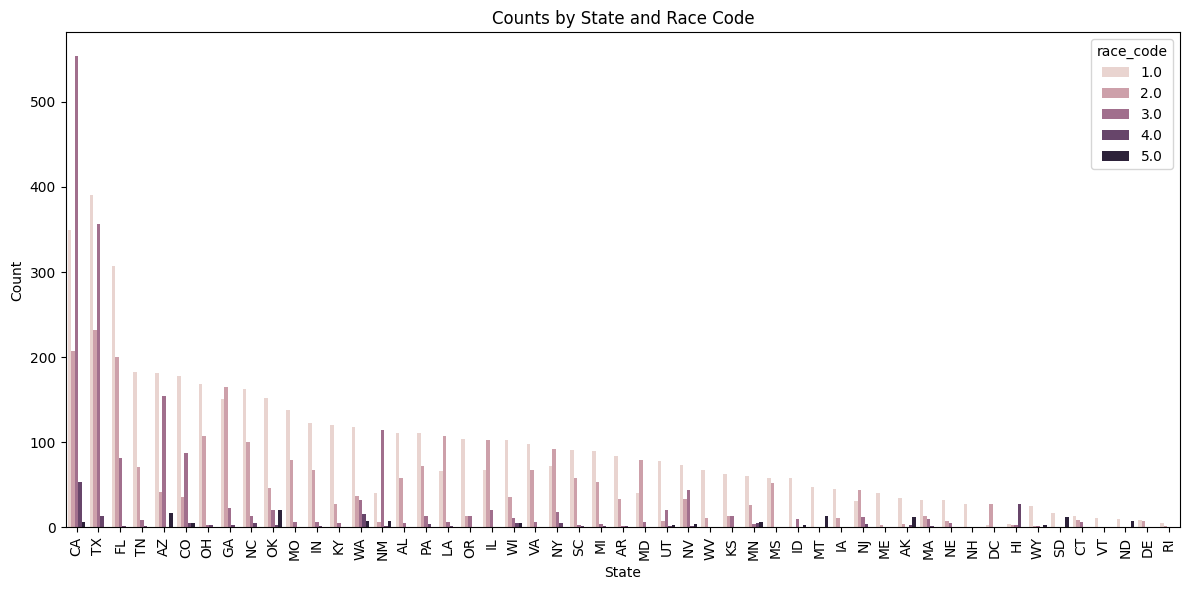

In [490]:
state_counts= fps[['state','race_code']].value_counts()
state_counts_df = state_counts.to_frame(name='counts')

# Plotting using Seaborn
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.barplot(x=state_counts_df.index.get_level_values(0),
            y=state_counts_df['counts'],
            hue=state_counts_df.index.get_level_values(1))
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.title('Counts by State and Race Code')
plt.xlabel('State')
plt.ylabel('Count')
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [506]:
fps1.dtypes

,0
id,int64
date,object
threat_type,object
flee_status,object
armed_with,object
city,object
state,object
latitude,float64
longitude,float64
location_precision,object


In [97]:
fps['threat_level'] = 'unknown'
fps1.loc[fps['armed_with'].isin(['unarmed', 'unknown', 'undetermined', 'other']), 'threat_level'] = 'low'
fps1.loc[fps['armed_with'].str.contains('gun|firearm', na=False), 'threat_level'] = 'high'
fps1.loc[(fps['armed_with'].str.contains('knife|blunt_object|replica', na=False)) &
        (fps['threat_level'] != 'high'), 'threat_level'] = 'medium'

In [513]:
fps1.head()

,id,date,threat_type,flee_status,armed_with,city,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids,race_code,threat_level
0,3,2015-01-02,point,not,gun,Shelton,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73,4.0,high
1,4,2015-01-02,point,not,gun,Aloha,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70,1.0,high
2,5,2015-01-03,move,not,unarmed,Wichita,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238,3.0,low
3,8,2015-01-04,point,not,replica,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196,1.0,medium
4,9,2015-01-04,point,not,other,Evans,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473,3.0,low


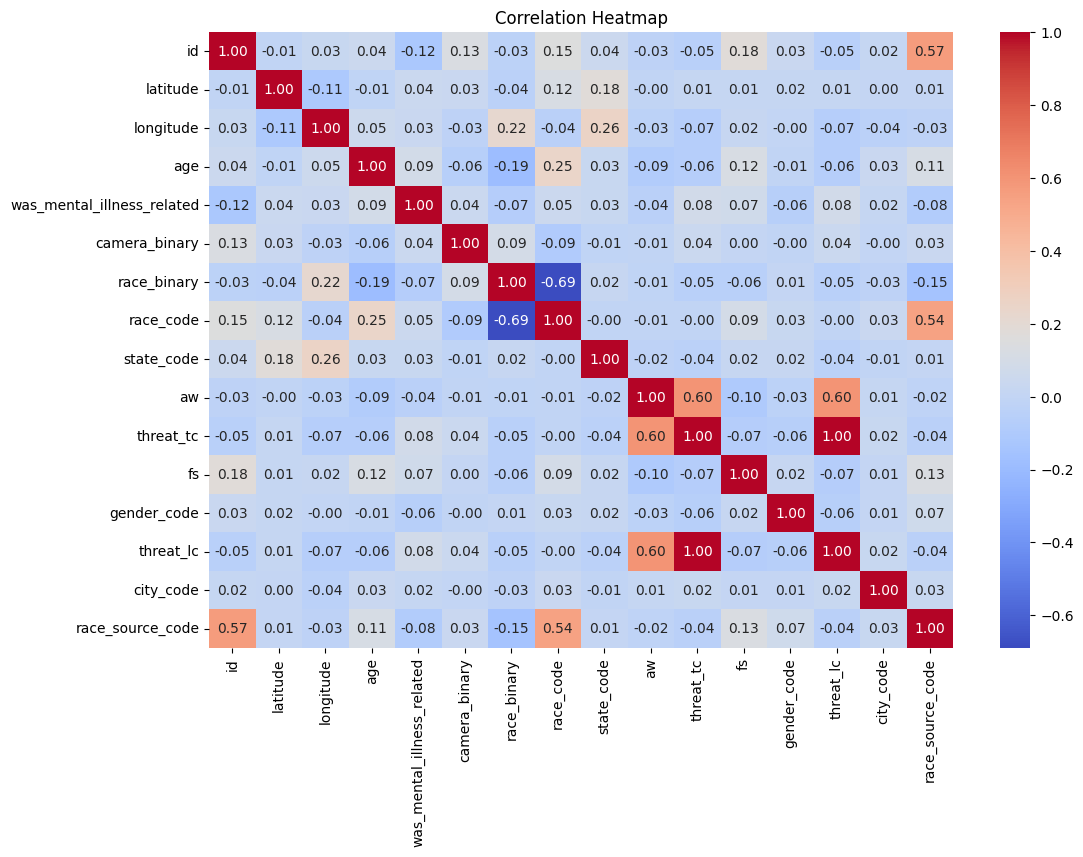

In [98]:
## Encoded correlation map ##
fps2=fps
fps2['date']= pd.to_datetime(fps['date'])

fps2['camera_binary'] = fps['body_camera'].astype(int)
fps2['race_binary'] = (fps['race'] == 'B').astype(int)
fps2['was_mental_illness_related'] = fps['was_mental_illness_related'].astype(int)


le = LabelEncoder()
fps2['state_code'] = le.fit_transform(fps1['state'])
fps2['aw'] = le.fit_transform(fps1['armed_with'])
fps2['threat_tc']= le.fit_transform(fps1['threat_level'])
fps2['fs']= le.fit_transform(fps1['flee_status'])
fps2['gender_code'] = le.fit_transform(fps1['gender'])
fps2['threat_lc'] = le.fit_transform(fps1['threat_level'])
fps2['city_code'] = le.fit_transform(fps1['city'])
fps2['race_source_code'] = le.fit_transform(fps1['race_source'])
fps2['race_code'] = le.fit_transform(fps1['race'])
fps_numeric = fps.select_dtypes(include=np.number)

corr_matrix = fps_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [17]:
fps2.head()

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,...,camera_binary,race_binary,state_code,aw,threat_tc,fs,gender_code,threat_lc,city_code,race_source_code
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,...,0,0,47,5,0,2,1,0,3072,1
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,...,0,0,37,5,0,2,1,0,49,1
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,...,0,0,16,23,1,2,1,1,3656,1
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,...,0,0,4,19,2,2,1,2,2964,1
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,...,0,0,5,15,1,2,1,1,1053,1


In [18]:
print(fps1['race'].value_counts(ascending=False))
print(fps1['flee_status'].value_counts())
print(fps1['body_camera'].value_counts())
print(fps1['armed_with'].value_counts())
print(fps1['state'].value_counts())
print(fps1['race_source'].value_counts())
print(fps1['threat_level'].value_counts())
print(fps1['gender'].value_counts())


race
W        4647
B        2479
H        1716
A         184
N         145
O          37
W;B         4
W;H         3
B;H         2
W;B;N       1
N;H         1
W;A         1
Name: count, dtype: int64
flee_status
not      5570
car      1632
foot     1345
other     384
Name: count, dtype: int64
body_camera
False    8634
True     1794
Name: count, dtype: int64
armed_with
gun                          6037
knife                        1774
unarmed                       564
undetermined                  468
vehicle                       372
replica                       331
blunt_object                  252
unknown                       165
other                         107
gun;knife                      42
gun;vehicle                    39
vehicle;gun                    25
knife;knife                     6
knife;blunt_object              5
blunt_object;blunt_object       4
other;gun                       4
knife;vehicle                   3
blunt_object;knife              3
vehicle;knife     

In [19]:
print(fps1[['race_code','age']].corr())
print(fps1[['race_code','longitude']].corr())
print(fps1[['race_code','latitude']].corr())
print(fps2[['race_code','state_code']].corr())
print(fps2[['race_code','aw']].corr())
print(fps2[['race_code','was_mental_illness_related']].corr())
print(fps2[['race_code','threat_lc']].corr())
print(fps2[['race_code','race_source_code']].corr())
print(fps2[['race_code','fs']].corr())


           race_code       age
race_code   1.000000  0.245291
age         0.245291  1.000000
           race_code  longitude
race_code   1.000000  -0.044817
longitude  -0.044817   1.000000
           race_code  latitude
race_code   1.000000  0.120009
latitude    0.120009  1.000000
            race_code  state_code
race_code    1.000000   -0.004057
state_code  -0.004057    1.000000
           race_code        aw
race_code   1.000000 -0.005937
aw         -0.005937  1.000000
                            race_code  was_mental_illness_related
race_code                    1.000000                    0.047367
was_mental_illness_related   0.047367                    1.000000
           race_code  threat_lc
race_code   1.000000  -0.003951
threat_lc  -0.003951   1.000000
                  race_code  race_source_code
race_code           1.00000           0.54231
race_source_code    0.54231           1.00000
           race_code        fs
race_code   1.000000  0.089439
fs          0.089439  1.00000

In [20]:
fps2['body_camera'] = fps2['body_camera'].astype(int)
fps2['race_binary'] = (fps2['race'] == 'B').astype(int)

In [310]:
grouped_age = fps.groupby(['age', 'race']).size().unstack(fill_value=0)

# Calculate the percentage of Black individuals shot at each age
grouped_age['black_age_percentage'] = grouped['B'] / (grouped['B'] + grouped['W'] + grouped['H']+ grouped['A'])

print(grouped_age['black_age_percentage'].sort_values().head(50))
fps['black_age_precentage'] =grouped_age['black_age_percentage']

age
2.0     0.000000
6.0     0.000000
12.0    0.000000
92.0    0.000000
91.0    0.000000
84.0    0.000000
85.0    0.000000
86.0    0.000000
80.0    0.000000
81.0    0.000000
83.0    0.000000
79.0    0.000000
76.0    0.000000
78.0    0.000000
75.0    0.000000
73.0    0.000000
70.0    0.066667
71.0    0.071429
64.0    0.073171
69.0    0.080000
65.0    0.083333
59.0    0.097561
50.0    0.105263
62.0    0.109091
56.0    0.117647
66.0    0.129032
72.0    0.142857
58.0    0.144444
53.0    0.152381
60.0    0.154930
49.0    0.162791
52.0    0.165217
51.0    0.165354
57.0    0.176471
44.0    0.178344
63.0    0.181818
54.0    0.187500
48.0    0.193333
46.0    0.193750
55.0    0.195402
14.0    0.200000
40.0    0.200935
43.0    0.210000
45.0    0.212435
34.0    0.224359
42.0    0.228723
68.0    0.230769
38.0    0.234310
35.0    0.241007
36.0    0.250000
Name: black_age_percentage, dtype: float64


In [21]:
fps2['flee_status'].unique()

array(['not', 'car', 'foot', 'other', nan], dtype=object)

In [22]:
prob_imputed = fps1

In [23]:
prob_imputed.shape

(10428, 31)

In [576]:
fps1.head()

,id,date,threat_type,flee_status,armed_with,city,state,latitude,longitude,location_precision,...,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids,race_code,threat_level,race_binary
0,3,2015-01-02,point,not,gun,Shelton,WA,47.246826,-123.121592,not_available,...,53.0,male,A,not_available,True,0,73,4.0,high,0
1,4,2015-01-02,point,not,gun,Aloha,OR,45.487421,-122.891696,not_available,...,47.0,male,W,not_available,False,0,70,1.0,high,0
2,5,2015-01-03,move,not,unarmed,Wichita,KS,37.694766,-97.280554,not_available,...,23.0,male,H,not_available,False,0,238,3.0,low,0
3,8,2015-01-04,point,not,replica,San Francisco,CA,37.762910,-122.422001,not_available,...,32.0,male,W,not_available,True,0,196,1.0,medium,0
4,9,2015-01-04,point,not,other,Evans,CO,40.383937,-104.692261,not_available,...,39.0,male,H,not_available,False,0,473,3.0,low,0


In [24]:
# # Applying probabilistic imputation to fill missing values.
# # Probabilistic imputation picks the best possible value based on the existing dataset.

# Iterate over each column and fill missing values based on existing distribution in the dataframe prob_imputed
for column in prob_imputed.columns:
    if column == 'race_binary':  # Skip the target variable
        continue

    if prob_imputed[column].isnull().any():
        # Calculate the distribution of the current column
        distribution = prob_imputed[column].dropna().value_counts(normalize=True)

        # Generate random values based on this distribution
        random_values = np.random.choice(distribution.index, size=prob_imputed[column].isnull().sum(), p=distribution.values)
        # Fill the missing values in the column with the generated random values
        prob_imputed.loc[prob_imputed[column].isnull(), column] = random_values
# Check if there are any null values left in the predictors
print(prob_imputed.drop(columns=['race_binary']).isnull().sum())

id                            0
date                          0
threat_type                   0
flee_status                   0
armed_with                    0
city                          0
county                        0
state                         0
latitude                      0
longitude                     0
location_precision            0
name                          0
age                           0
gender                        0
race                          0
race_source                   0
was_mental_illness_related    0
body_camera                   0
agency_ids                    0
race_code                     0
threat_level                  0
camera_binary                 0
state_code                    0
aw                            0
threat_tc                     0
fs                            0
gender_code                   0
threat_lc                     0
city_code                     0
race_source_code              0
dtype: int64


In [25]:
encoded_df =fps2

In [26]:
fps2.dtypes

,0
id,int64
date,datetime64[ns]
threat_type,object
flee_status,object
armed_with,object
city,object
county,object
state,object
latitude,float64
longitude,float64


In [27]:
encoded_df.drop(columns=encoded_df.select_dtypes((object)).columns, inplace=True)

In [28]:
encoded_df.dtypes

,0
id,int64
date,datetime64[ns]
latitude,float64
longitude,float64
age,float64
was_mental_illness_related,int64
body_camera,int64
race_code,int64
camera_binary,int64
race_binary,int64


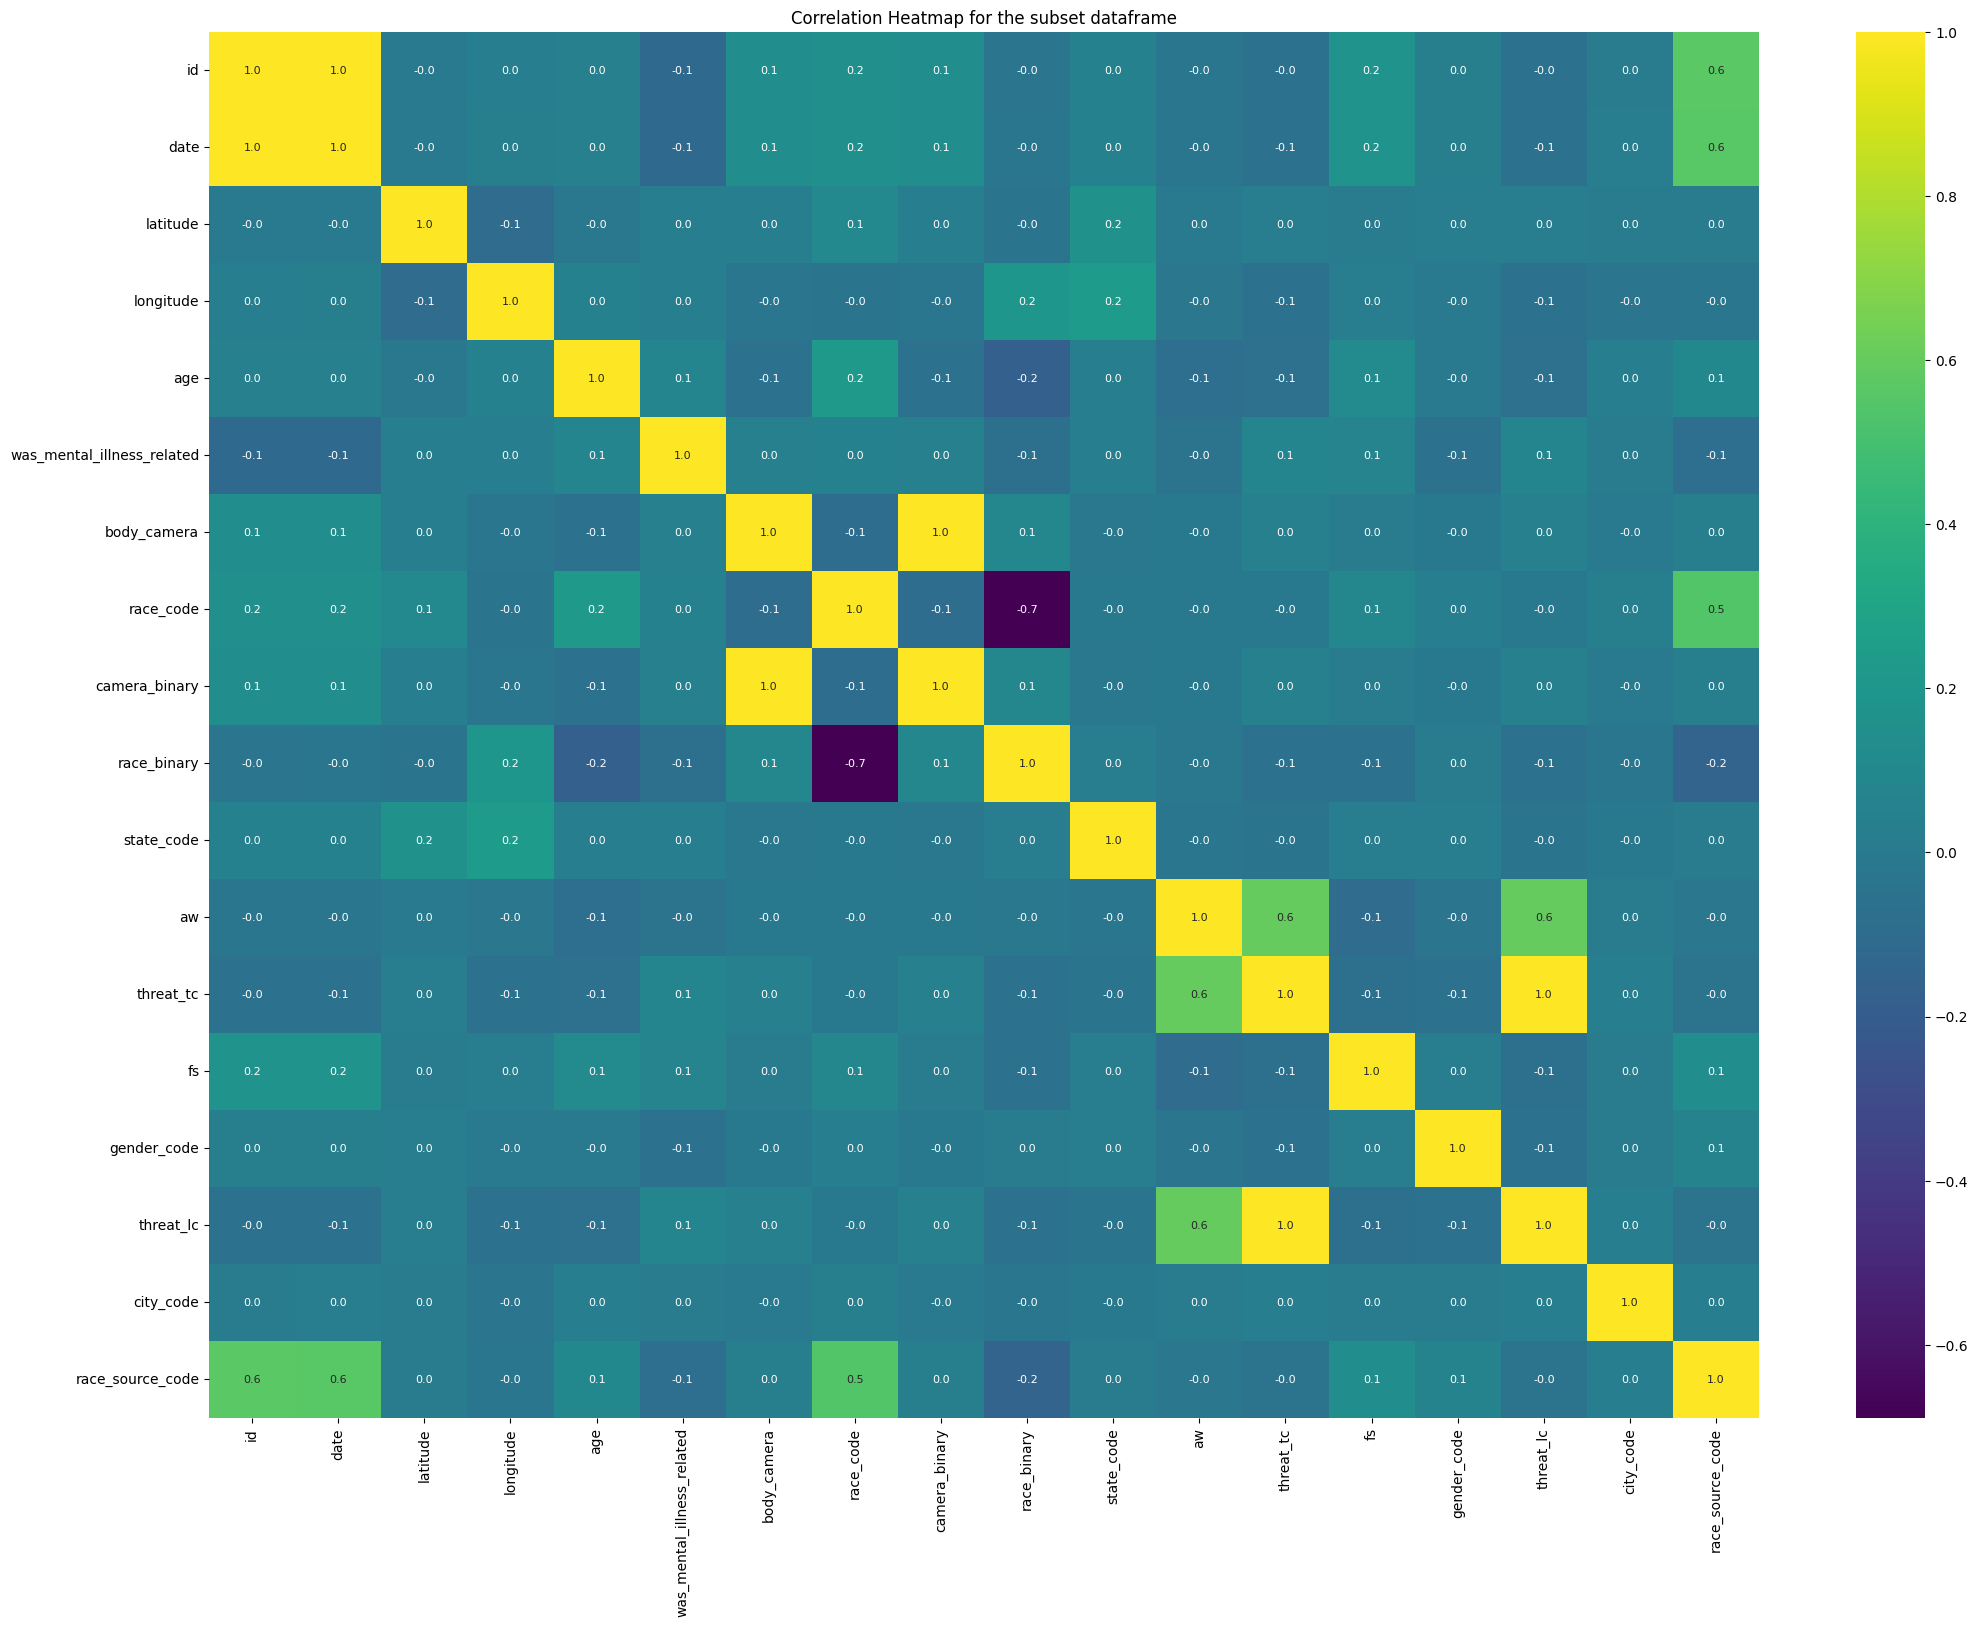

In [29]:
# Calculating the correlation matrix for the encoded dataframe
encoded_dfCorr = encoded_df.corr()

# plot Heatmap
plt.figure(figsize=(25, 18))
sns.heatmap(encoded_dfCorr, annot=True, cmap='viridis', fmt=".1f", annot_kws={"size": 8})
plt.title('Correlation Heatmap for the subset dataframe')
plt.show()

In [44]:
# 'encoded_df' is the DataFrame and 'colo_cancer' is the target variable
target_variable = encoded_df['race_binary'].copy()
predictors = encoded_df.drop(columns=['race_binary'])

In [31]:
predictors1= predictors

In [45]:
predictors.reset_index(drop=True, inplace=True)


In [46]:
target_variable = target_variable.reset_index(drop=True)

In [33]:
assert len(predictors) == len(target_variable)

In [47]:
len(target_variable)

10428

In [48]:
len(predictors)

10428

In [38]:
predictors1.drop(columns=['race_code'],inplace=True)

In [49]:
# Chi-Square Test

from scipy.stats import chi2_contingency
import pandas as pd

# target_variable is already correctly defined and contains the target data

# Initialize an empty list to store the results
chi_square_results = []

for column in predictors1.columns:  # encoded_df is the DataFrame with encoded predictors
    # Create a contingency table
    crosstab = pd.crosstab(predictors1[column], target_variable)

    # Perform the chi-square test
    chi2, p, dof, ex = chi2_contingency(crosstab, correction=False)  # Use correction=False for Yates' correction in large samples

    # Append the results to the list as a dictionary
    chi_square_results.append({"Variable": column, "Chi-square Statistic": chi2, "P-value": p})

# Create a DataFrame from the list of dictionaries
chi_results = pd.DataFrame(chi_square_results)

pd.set_option('display.max_rows', 100)  # or another number large enough to display your full results

# Display the resulting DataFrame
#print(chi_results)

# Optionally, we can sort by P-value to see the most significant variables first
chi_results_sorted = chi_results.sort_values(by="P-value")
print(chi_results_sorted)

                      Variable  Chi-square Statistic        P-value
8                   state_code           1023.511445  9.838519e-182
15            race_source_code            435.883688   5.354223e-91
4                          age            463.414859   3.288953e-54
14                   city_code           4806.889159   1.387804e-29
11                          fs            127.874863   1.108719e-26
6                  body_camera             93.358012   4.364113e-22
7                camera_binary             93.358012   4.364113e-22
5   was_mental_illness_related             53.177392   3.047460e-13
13                   threat_lc             51.529750   3.772432e-11
10                   threat_tc             51.529750   3.772432e-11
9                           aw             99.233478   2.452706e-09
12                 gender_code             17.039351   6.936937e-04
2                     latitude           9312.363867   2.760495e-01
3                    longitude           9298.10

In [51]:
# This should help to see which columns are being processed
for column in predictors1.columns:
    print(f"Processing column: {column}")

Processing column: id
Processing column: date
Processing column: latitude
Processing column: longitude
Processing column: age
Processing column: was_mental_illness_related
Processing column: body_camera
Processing column: camera_binary
Processing column: state_code
Processing column: aw
Processing column: threat_tc
Processing column: fs
Processing column: gender_code
Processing column: threat_lc
Processing column: city_code
Processing column: race_source_code


In [55]:
print(target_variable)

0        0
1        0
2        0
3        0
4        0
        ..
10423    0
10424    1
10425    0
10426    0
10427    0
Name: race_binary, Length: 10428, dtype: int64


In [625]:
predictors['body_camera'] = (predictors['body_camera'] == 'B').astype(int)


In [42]:
# # Applying probabilistic imputation to fill missing values.
# # Probabilistic imputation picks the best possible value based on the existing dataset.

# Iterate over each column and fill missing values based on existing distribution in the dataframe prob_imputed
for column in predictors.columns:
    if column == 'race_binary':  # Skip the target variable
        continue

    if predictors[column].isnull().any():
        # Calculate the distribution of the current column
        distribution = predictors[column].dropna().value_counts(normalize=True)

        # Generate random values based on this distribution
        random_values = np.random.choice(distribution.index, size=predictors[column].isnull().sum(), p=distribution.values)
        # Fill the missing values in the column with the generated random values
        predictors.loc[predictors[column].isnull(), column] = random_values
# Check if there are any null values left in the predictors
print(predictors.isnull().sum())

id                            0
date                          0
latitude                      0
longitude                     0
age                           0
was_mental_illness_related    0
body_camera                   0
camera_binary                 0
state_code                    0
aw                            0
threat_tc                     0
fs                            0
gender_code                   0
threat_lc                     0
city_code                     0
race_source_code              0
dtype: int64


In [65]:
y=target_variable
X=predictors1.drop(columns='date')

In [60]:
fps2.dtypes

,0
id,int64
date,datetime64[ns]
latitude,float64
longitude,float64
age,float64
was_mental_illness_related,int64
body_camera,int64
race_code,int64
camera_binary,int64
race_binary,int64


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X, y)
y_pred = model.predict(X)

print('\nLogistic Regression\n')
print(classification_report(y, y_pred))

# Feature importance
importance = model.coef_[0]
for col, coef in zip(X.columns, importance):
    print(f"{col}: {coef:.4f}")



Logistic Regression

              precision    recall  f1-score   support

           0       0.77      0.98      0.87      7949
           1       0.57      0.09      0.15      2479

    accuracy                           0.77     10428
   macro avg       0.67      0.53      0.51     10428
weighted avg       0.73      0.77      0.70     10428

id: 0.0001
latitude: 0.0392
longitude: 0.0215
age: -0.0268
was_mental_illness_related: -0.2882
body_camera: 0.3683
camera_binary: 0.3683
state_code: 0.0000
aw: 0.0171
threat_tc: -0.1271
fs: -0.0226
gender_code: 0.2692
threat_lc: -0.1271
city_code: 0.0000
race_source_code: -0.2863


In [ ]:
fps['fs'] = fps['flee_status'].map({
    'not':1,
    'car': 2,
    'foot': 3,
    'other': 4,
    'nan': 5,
})
print(fps['fs'].value_counts())

In [320]:
grouped_fs = fps.groupby(['fs', 'race']).size().unstack(fill_value=0)

# Calculate the percentage of Black individuals shot at each age
grouped_fs['black_fs_percentage'] = grouped['B'] / (grouped['B'] + grouped['W'] + grouped['H']+ grouped['A'])

print(grouped_fs['black_fs_percentage'].sort_values().head(50))
fps['black_fs_precentage'] =grouped_fs['black_fs_percentage']

fs
2    0.0
4    1.0
0    NaN
1    NaN
3    NaN
Name: black_fs_percentage, dtype: float64


In [311]:
fps.head()

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,...,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids,race_code,threat_level,black_precentage,black_age_precentage
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,...,male,A,not_available,True,False,73,4.0,high,NaN,NaN
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,...,male,W,not_available,False,False,70,1.0,high,NaN,NaN
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,...,male,H,not_available,False,False,238,3.0,low,0.0,0.0
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,...,male,W,not_available,True,False,196,1.0,medium,NaN,NaN
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,...,male,H,not_available,False,False,473,3.0,low,1.0,1.0


In [ ]:
grouped.head(9)

In [ ]:
print("\nClass Distribution:")
print(fps['race_binary'].value_counts(normalize=True))


Class Distribution:
race_binary
0    0.762275
1    0.237725
Name: proportion, dtype: float64


In [ ]:
X.head(15)

,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race_source,was_mental_illness_related,body_camera,agency_ids,race_code,threat_level
0,0,0,0,0,0,0,47.246826,-123.121592,0,0,1.200714,0,0,True,0,0,4.0,0
1,0,0,0,1,1,1,45.487421,-122.891696,0,1,0.736797,0,0,False,0,1,1.0,0
2,1,0,1,2,2,2,37.694766,-97.280554,0,2,-1.118869,0,0,False,0,2,3.0,1
3,0,0,2,3,3,3,37.762910,-122.422001,0,3,-0.422994,0,0,True,0,3,1.0,2
4,0,0,3,4,4,4,40.383937,-104.692261,0,4,0.118242,0,0,False,0,4,3.0,1
5,2,0,0,5,5,5,35.876991,-97.423454,0,5,-1.505466,0,0,False,0,5,1.0,0
6,3,1,0,6,6,6,33.327887,-111.840959,0,6,-1.196188,0,0,False,0,6,3.0,0
7,0,0,0,7,7,2,38.703755,-97.563904,0,7,-0.191036,0,0,False,0,7,1.0,0
8,4,0,1,8,8,7,40.809250,-91.118875,0,8,-0.268355,1,0,False,1,8,1.0,1
9,0,0,2,9,9,8,40.412936,-79.991408,0,9,0.736797,0,0,False,0,9,2.0,2


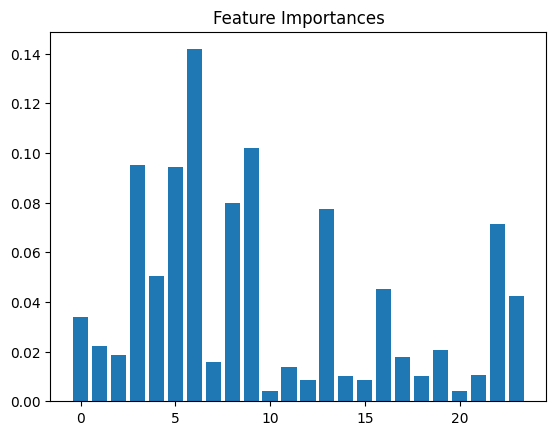

In [711]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances")
plt.show()



Log
Cross-validated scores: [0.76213301 0.76512882 0.76438849 0.76258993 0.75959233]
Mean CV Accuracy: 0.7627665153676938
Accuracy: 0.7627

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1590
           1       0.51      0.07      0.13       496

    accuracy                           0.76      2086
   macro avg       0.64      0.53      0.50      2086
weighted avg       0.71      0.76      0.69      2086

Confusion Matrix:
[[1554   36]
 [ 459   37]]
ROC-AUC Score: 0.6838


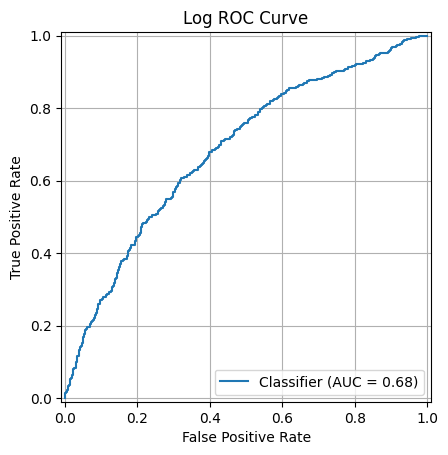


KNN
Cross-validated scores: [0.72079089 0.73636908 0.73261391 0.73201439 0.74160671]
Mean CV Accuracy: 0.7326789976047922
Accuracy: 0.7205

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1590
           1       0.40      0.34      0.36       496

    accuracy                           0.72      2086
   macro avg       0.60      0.59      0.59      2086
weighted avg       0.71      0.72      0.71      2086

Confusion Matrix:
[[1336  254]
 [ 329  167]]
ROC-AUC Score: 0.6279


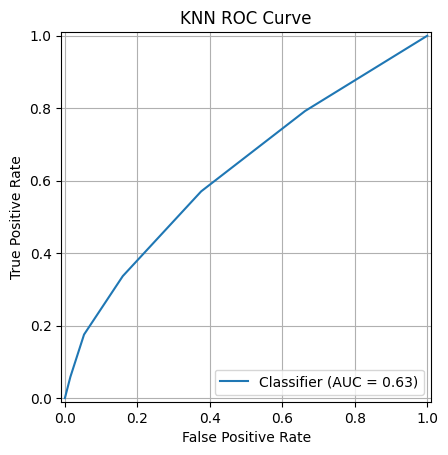


XGBoost
Cross-validated scores: [0.7669263  0.77890953 0.76199041 0.77577938 0.7763789 ]
Mean CV Accuracy: 0.7719969021786764
Accuracy: 0.7771

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1590
           1       0.55      0.35      0.43       496

    accuracy                           0.78      2086
   macro avg       0.68      0.63      0.64      2086
weighted avg       0.75      0.78      0.76      2086

Confusion Matrix:
[[1448  142]
 [ 323  173]]
ROC-AUC Score: 0.7340


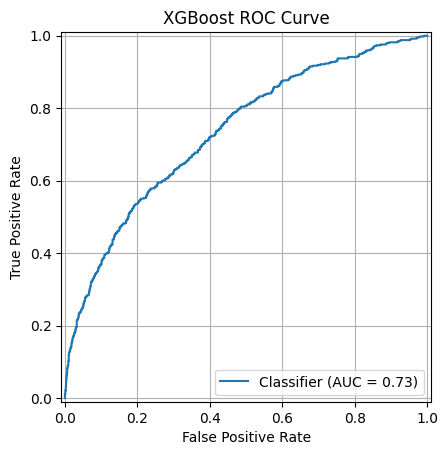


Random Forest
Cross-validated scores: [0.77531456 0.78070701 0.77158273 0.77218225 0.77338129]
Mean CV Accuracy: 0.7746335705551796
Accuracy: 0.7790

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1590
           1       0.56      0.33      0.41       496

    accuracy                           0.78      2086
   macro avg       0.69      0.62      0.64      2086
weighted avg       0.75      0.78      0.76      2086

Confusion Matrix:
[[1463  127]
 [ 334  162]]
ROC-AUC Score: 0.7384


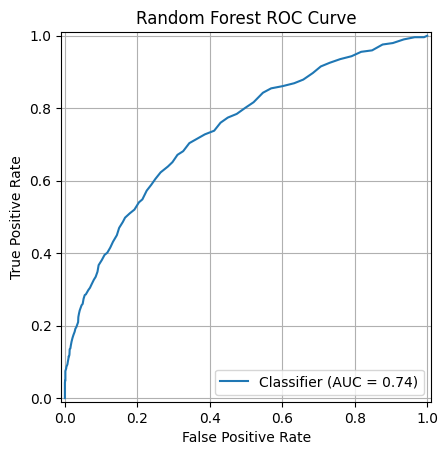


Decision Tree
Cross-validated scores: [0.74835231 0.73097663 0.73681055 0.75419664 0.75059952]
Mean CV Accuracy: 0.7441871308226038
Accuracy: 0.7344

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1590
           1       0.42      0.31      0.36       496

    accuracy                           0.73      2086
   macro avg       0.61      0.59      0.60      2086
weighted avg       0.71      0.73      0.72      2086

Confusion Matrix:
[[1376  214]
 [ 340  156]]
ROC-AUC Score: 0.6706


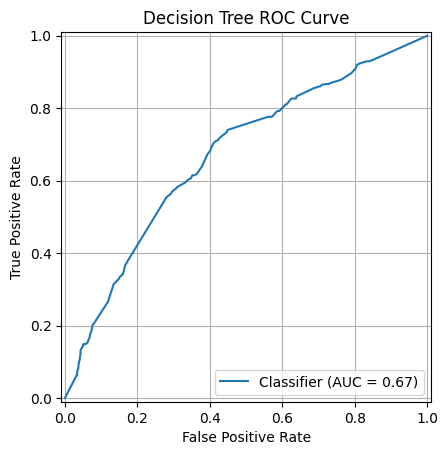


Gradient Boosting
Cross-validated scores: [0.76992211 0.76752546 0.77458034 0.76498801 0.77098321]
Mean CV Accuracy: 0.7695998264300483
Accuracy: 0.7752

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1590
           1       0.60      0.16      0.26       496

    accuracy                           0.78      2086
   macro avg       0.69      0.56      0.56      2086
weighted avg       0.74      0.78      0.72      2086

Confusion Matrix:
[[1536   54]
 [ 415   81]]
ROC-AUC Score: 0.7434


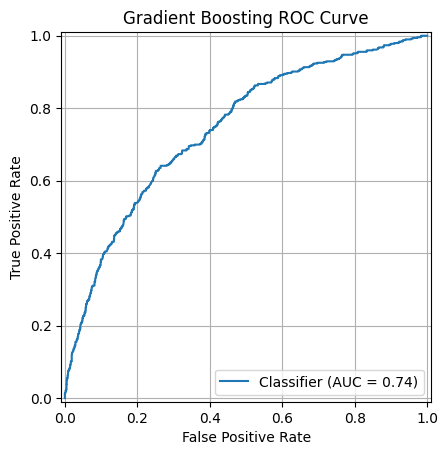


AdaBoost
Cross-validated scores: [0.76273217 0.76153385 0.76139089 0.76498801 0.76318945]
Mean CV Accuracy: 0.7627668745770311
Accuracy: 0.7622

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1590
           1       0.50      0.08      0.13       496

    accuracy                           0.76      2086
   macro avg       0.64      0.53      0.50      2086
weighted avg       0.71      0.76      0.69      2086

Confusion Matrix:
[[1552   38]
 [ 458   38]]
ROC-AUC Score: 0.7039


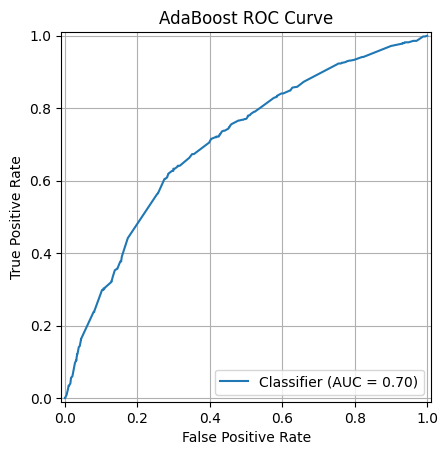

In [81]:
## ML models before tunnning ##

## FEATURES & TARGET ##
X = fps2.drop(columns=["race_binary",'race_code'])
y = fps2["race_binary"]


## Preprocessing ##
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object", "bool"]).columns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

adasyn = SMOTE(sampling_strategy=0.4, random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train_proc, y_train)

## Models (no tuning) ##
models = {
    "Log": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=101),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=101),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=101),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=101),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=101)
}

## Evaluation ##
def train_evaluate(name, model):
    print(f"\n{name}")

    # Cross-validation on training set (before resampling)
    scores = cross_val_score(model, X_train_proc, y_train, cv=5, scoring='accuracy')
    print("Cross-validated scores:", scores)
    print("Mean CV Accuracy:", scores.mean())

    # Fit on resampled training data
    model.fit(X_train_res, y_train_res)

    # Predict on test data
    y_pred = model.predict(X_test_proc)
    y_proba = model.predict_proba(X_test_proc)[:, 1]

    # Evaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.xlabel(f'False Positive Rate')
    plt.ylabel(f'True Positive Rate')
    plt.title(f"{name} ROC Curve")
    plt.grid(True)
    plt.show()

for name, model in models.items():
    train_evaluate(name, model)



Log
Cross-validated scores: [0.7639305  0.76452966 0.76498801 0.78177458 0.78117506]
Mean CV Accuracy: 0.7712795611324003
Best Params: {'C': 10, 'penalty': 'l2'}
Accuracy: 0.7742

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1590
           1       0.55      0.30      0.39       496

    accuracy                           0.77      2086
   macro avg       0.68      0.61      0.62      2086
weighted avg       0.75      0.77      0.75      2086

Confusion Matrix:
[[1466  124]
 [ 347  149]]
ROC-AUC Score: 0.7335


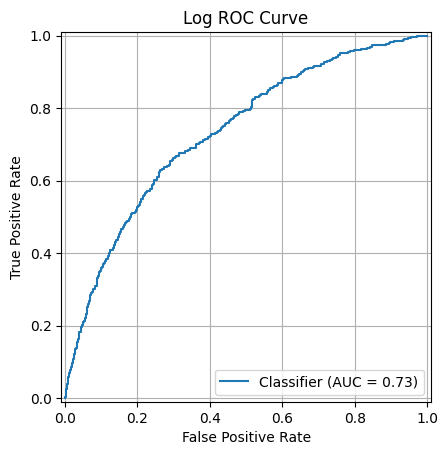


KNN
Cross-validated scores: [0.74715398 0.72857999 0.75419664 0.73321343 0.75659472]
Mean CV Accuracy: 0.7439477537203312
Best Params: {'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 0.7526

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1590
           1       0.48      0.40      0.44       496

    accuracy                           0.75      2086
   macro avg       0.65      0.63      0.64      2086
weighted avg       0.74      0.75      0.75      2086

Confusion Matrix:
[[1371  219]
 [ 297  199]]
ROC-AUC Score: 0.6902


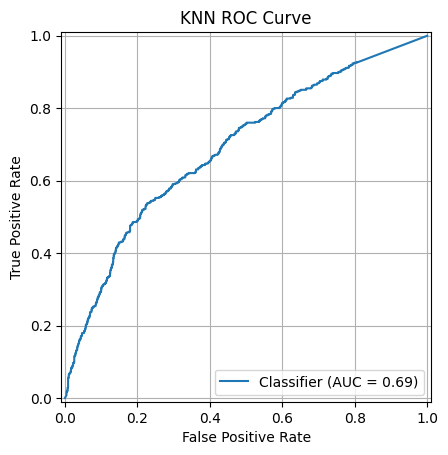


XGBoost
Cross-validated scores: [0.7962852  0.7747154  0.79676259 0.7853717  0.79376499]
Mean CV Accuracy: 0.7893799759473428
Best Params: {'learning_rate': 0.1, 'max_depth': 23, 'n_estimators': 150}
Accuracy: 0.7895

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1590
           1       0.58      0.41      0.48       496

    accuracy                           0.79      2086
   macro avg       0.71      0.66      0.67      2086
weighted avg       0.77      0.79      0.78      2086

Confusion Matrix:
[[1446  144]
 [ 295  201]]
ROC-AUC Score: 0.7726


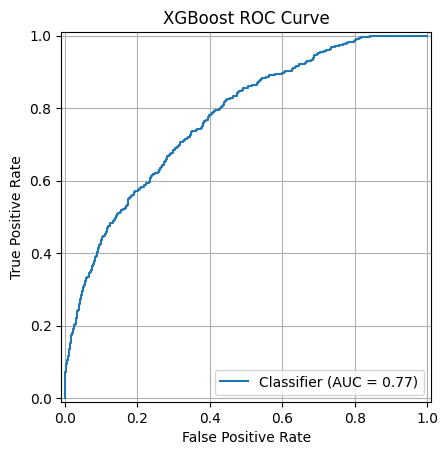


Random Forest
Cross-validated scores: [0.79209107 0.77711204 0.78776978 0.78357314 0.80215827]
Mean CV Accuracy: 0.7885408629357749
Best Params: {'max_depth': None, 'n_estimators': 250}
Accuracy: 0.8001

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      1590
           1       0.64      0.36      0.46       496

    accuracy                           0.80      2086
   macro avg       0.73      0.65      0.67      2086
weighted avg       0.78      0.80      0.78      2086

Confusion Matrix:
[[1491   99]
 [ 318  178]]
ROC-AUC Score: 0.7772


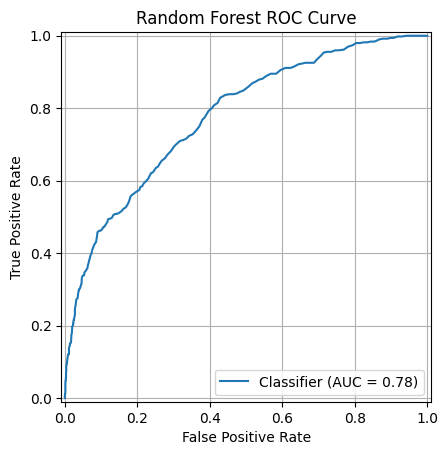


Decision Tree
Cross-validated scores: [0.70401438 0.73037747 0.70863309 0.70743405 0.72122302]
Mean CV Accuracy: 0.7143364038547473
Best Params: {'max_depth': 5, 'min_samples_split': 2}
Accuracy: 0.7776

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.86      1590
           1       0.56      0.30      0.39       496

    accuracy                           0.78      2086
   macro avg       0.68      0.61      0.63      2086
weighted avg       0.75      0.78      0.75      2086

Confusion Matrix:
[[1471  119]
 [ 345  151]]
ROC-AUC Score: 0.7380


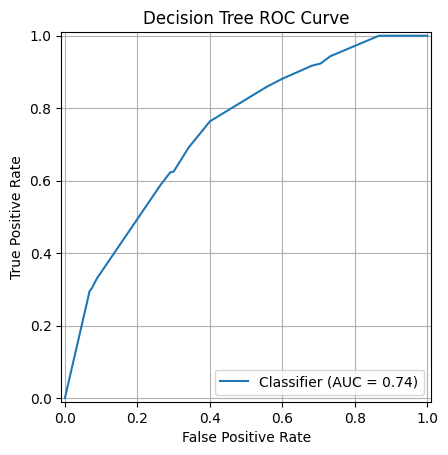


Gradient Boosting
Cross-validated scores: [0.79089275 0.78010785 0.7823741  0.80455635 0.79736211]
Mean CV Accuracy: 0.7910586330216833
Best Params: {'learning_rate': 0.2, 'max_depth': 13, 'n_estimators': 150}
Accuracy: 0.8030

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1590
           1       0.63      0.41      0.50       496

    accuracy                           0.80      2086
   macro avg       0.73      0.67      0.69      2086
weighted avg       0.79      0.80      0.79      2086

Confusion Matrix:
[[1473  117]
 [ 294  202]]
ROC-AUC Score: 0.7760


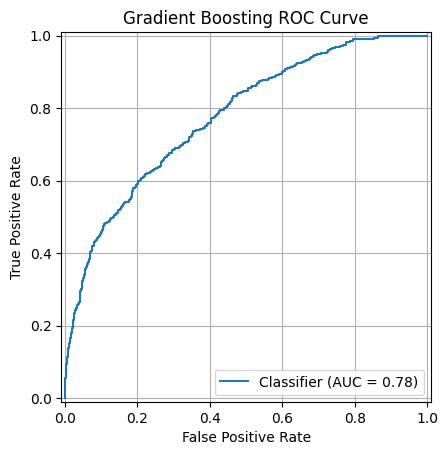


AdaBoost
Cross-validated scores: [0.76932295 0.7639305  0.76858513 0.77338129 0.77098321]
Mean CV Accuracy: 0.7692406170929045
Best Params: {'learning_rate': 1.5, 'n_estimators': 150}
Accuracy: 0.7852

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1590
           1       0.57      0.38      0.45       496

    accuracy                           0.79      2086
   macro avg       0.70      0.64      0.66      2086
weighted avg       0.76      0.79      0.77      2086

Confusion Matrix:
[[1451  139]
 [ 309  187]]
ROC-AUC Score: 0.7702


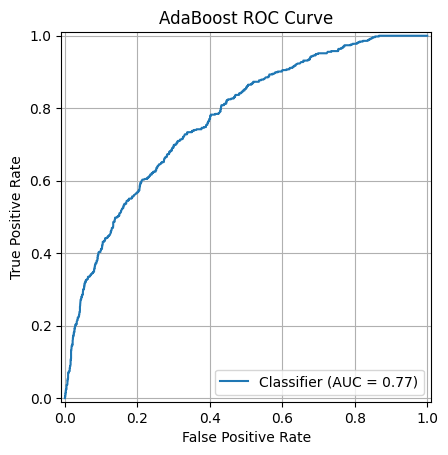

In [84]:
## ML Models and after grid search ##


## FEATURES & TARGET ##
X = predictors1
y = target_variable


## PREPROCESSING SETUP ##
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object", "bool"]).columns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

## TRAIN TEST SPLIT ##
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## TRANSFORM DATA ##
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

## BALANCE DATA ##
adasyn = SMOTE(sampling_strategy=.4, random_state=42
)

X_train_res, y_train_res = adasyn.fit_resample(X_train_proc, y_train)

## Models & Tunning ##
models = {
     "Log":{
        'estimator': LogisticRegression(max_iter=1000),
            "param_grid": {
            "C": [ 1, 10, 20, 30, 100],
            "penalty": ["l1", "l2"]
        }
    },

     "KNN": {
      "estimator": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 7,9,11,13],
            "weights": ["uniform", "distance"]
        }
    },
    "XGBoost": {
        "estimator": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=101),
        "param_grid": {
            "n_estimators": [50,75, 100, 150],
            "max_depth": [11,15,19, 23],
            "learning_rate": [0.1, 0.2]
        }
    },
    "Random Forest": {
        "estimator": RandomForestClassifier(random_state=101),
        "param_grid": {
            "n_estimators": [100, 200, 250],
            "max_depth": [None, 10, 20],
        }
    },
    "Decision Tree": {
        "estimator": DecisionTreeClassifier(random_state=101),
        "param_grid": {
            "max_depth": [None,  5, ],
            "min_samples_split": [2, 5, 10]
        }
    },
    "Gradient Boosting": {
        "estimator": GradientBoostingClassifier(random_state=101),
        "param_grid": {
            "n_estimators": [100, 150],
            "learning_rate": [0.05, 0.2],
            "max_depth": [3, 9, 11,13]
        }
    },
    "AdaBoost": {
        "estimator": AdaBoostClassifier(random_state=101),
        "param_grid": {
            "n_estimators": [50, 100, 150],
            "learning_rate": [1.0, 1.5, 2]
        }
    }
}


## Training & evaluating ##
def train_evaluate(name, estimator, param_grid):
    print(f"\n{name}")

    # Cross-validation on original training data (before resampling)
    raw_model = estimator.__class__(**estimator.get_params())
    scores = cross_val_score(raw_model, X_train_proc, y_train, cv=5, scoring='accuracy')
    print("Cross-validated scores:", scores)
    print("Mean CV Accuracy:", scores.mean())


    # GridSearchCV on resampled training data
    clf = GridSearchCV(estimator, param_grid, cv=3, scoring="roc_auc", n_jobs=-1)
    clf.fit(X_train_res, y_train_res)
    best_model = clf.best_estimator_

    y_pred = best_model.predict(X_test_proc)
    y_proba = best_model.predict_proba(X_test_proc)[:, 1]

    # Evaluation
    print(f"Best Params: {clf.best_params_}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"{name} ROC Curve")
    plt.xlabel(f'False Positive Rate')
    plt.ylabel(f'True Positive Rate')
    plt.grid(True)
    plt.show()


for name, config in models.items():
    train_evaluate(name, config["estimator"], config["param_grid"])


## Black v All Races ##


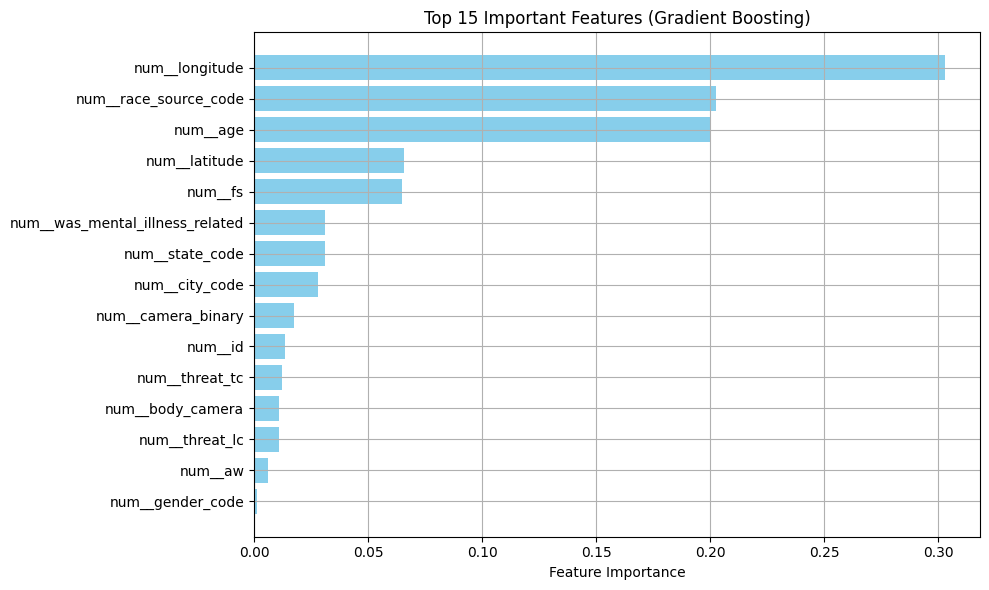

In [85]:
import pandas as pd
import matplotlib.pyplot as plt

# Refit Gradient Boosting on full preprocessed and resampled data
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=101)
gb_model.fit(X_train_res, y_train_res)

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Get feature importances
importances = gb_model.feature_importances_

# Create a DataFrame for better plotting
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort by importance
feat_imp = feat_imp.sort_values(by="Importance", ascending=False).head(15)  # top 15 features

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features (Gradient Boosting)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


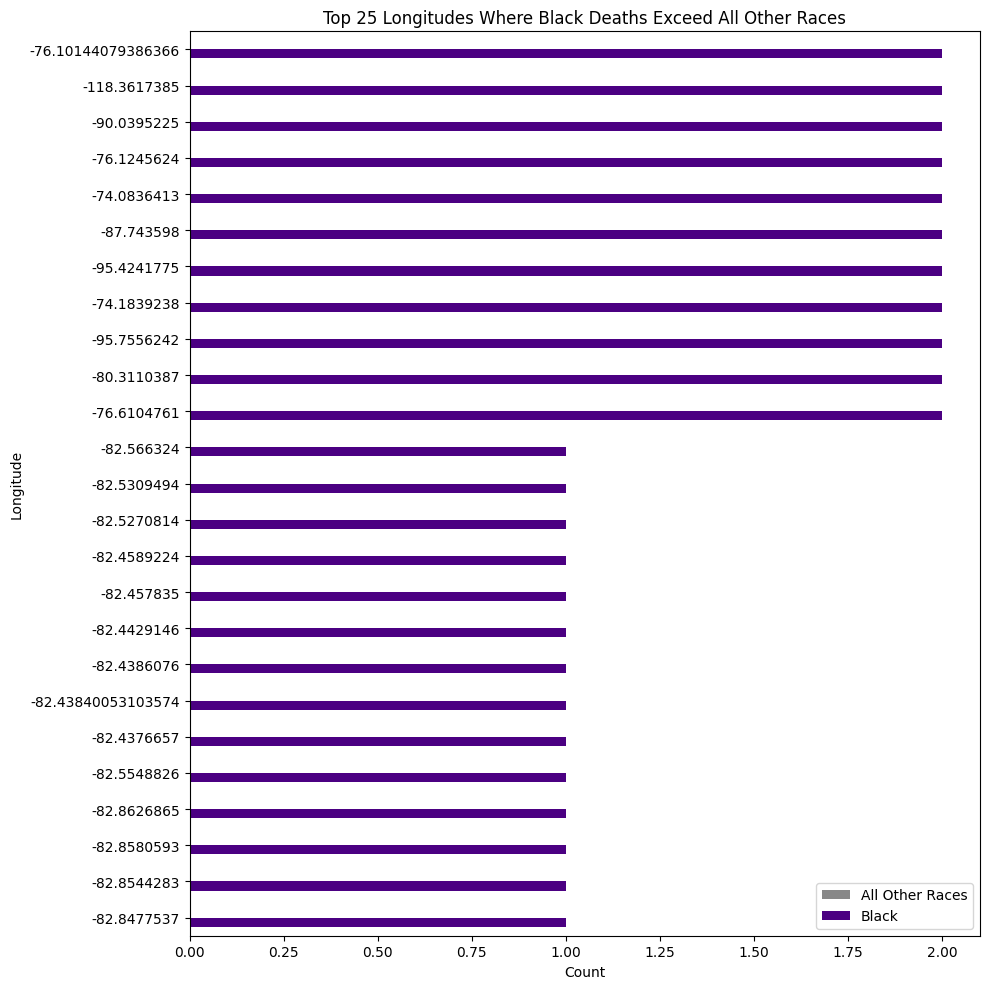

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by longitude and race_binary
longitude_race_counts = fps2.groupby(['longitude', 'race_binary']).size().unstack(fill_value=0)

# Filter: only longitudes where Black deaths > All Other deaths
black_dominant = longitude_race_counts[longitude_race_counts[1] > longitude_race_counts[0]]

# Sort by number of Black deaths
black_dominant_sorted = black_dominant.sort_values(by=1, ascending=False).head(25)

# Plot
black_dominant_sorted.plot(kind='barh', figsize=(10, 10), color=['#888', '#4B0082'])

plt.title("Top 25 Longitudes Where Black Deaths Exceed All Other Races")
plt.xlabel("Count")
plt.ylabel("Longitude")
plt.legend(["All Other Races", "Black"])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [712]:
fps2.dtypes

,0
id,int64
date,datetime64[ns]
latitude,float64
longitude,float64
age,float64
was_mental_illness_related,int64
body_camera,int64
camera_binary,int64
race_binary,int64
state_code,int64


In [471]:
test_results = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted_Logistic": y_pred_log,
    "Predicted_RandomForest": y_pred_rf
    "KNN": y_pred_knn
    "XGB": y_pred_xgb
    "RF": y_pred_rf
    "DT": y_pred_dt
    "GB": y_pred_gb
    "AB": y_pred_ab
})

print(test_results.head(7))

   Actual  Predicted_Logistic  Predicted_RandomForest
0       1                   0                       0
1       1                   0                       0
2       0                   0                       0
3       0                   0                       0
4       0                   0                       0
5       0                   0                       0
6       0                   1                       0


In [108]:
fps2['race_binary'].isnull()

,race_binary
0,False
1,False
2,False
3,False
4,False
...,...
10423,False
10424,False
10425,False
10426,False


In [ ]:
fps2['longitude'].isnull()

In [106]:
# Replace inf and nan in 'longitude' with median value
median_longitude = fps2['longitude'].median()
fps2['longitude'] = fps2['longitude'].replace([np.inf, -np.inf], np.nan).fillna(median_longitude)

X = sm.add_constant(fps2['longitude'])
y = fps2['race_binary']
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            race_binary   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     460.4
Date:                Fri, 25 Apr 2025   Prob (F-statistic):          5.56e-100
Time:                        03:08:12   Log-Likelihood:                -5665.4
No. Observations:               10428   AIC:                         1.133e+04
Df Residuals:                   10426   BIC:                         1.135e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7850      0.026     30.391      0.0

In [ ]:
fps.to_csv('fps.csv', index=False)
from google.colab import files
files.download('fps.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>